In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import statsmodels.api as sm

In [158]:
trait, indiv_group = "LDL", "white"
trait, indiv_group = "height", "other"

In [159]:
# read data
# prefix = f"out/OLD-pgs-interact/model-fit/joint+interact/{trait}-{indiv_group}"
prefix = f"out/model-fit/joint+slope/{trait}-{indiv_group}"

df_predint = pd.read_csv(f"{prefix}.predint.tsv", sep="\t", index_col=0)
df_params = pd.read_csv(f"{prefix}.params.tsv", sep="\t", index_col=0)
df_raw = pd.read_csv(
    f"../compile-data/out/per-trait-info/{trait}.tsv.gz", sep="\t", index_col=0
)

# Example

two males, same pred, different cal

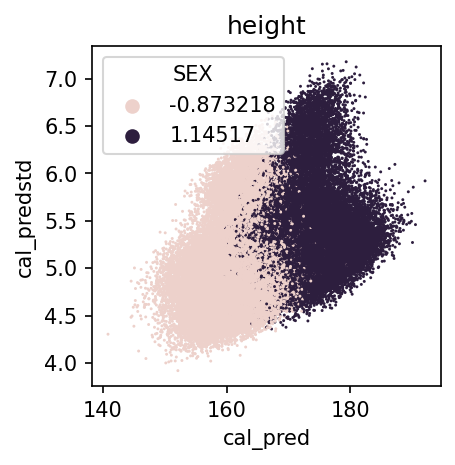

In [160]:
# visualize
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(
    data=df_predint, x="cal_pred", y="cal_predstd", linewidth=0, s=2, hue="SEX"
)
ax.set_title(trait)
fig.show()

In [166]:
def plot_group(df, group):
    if len(np.unique(df[group])) > 5:
        q_var = pd.qcut(df[group], 5).cat.codes
    else:
        q_var = df[group]

    # visualize
    fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
    sns.scatterplot(data=df, x="cal_pred", y="pheno", linewidth=0, s=2, hue=q_var)

    for q, df_q in df.groupby(q_var):
        sns.regplot(
            data=df_q,
            x="cal_pred",
            y="pheno",
            scatter=False,
            label=q,
        )

    ax.axline(
        (df.pheno.mean(), df.pheno.mean()),
        slope=1,
        color="black",
        ls="--",
    )
    ax.legend(ncol=len(np.unique(q_var)), fontsize=5)
    ax.set_title(trait)
    fig.show()

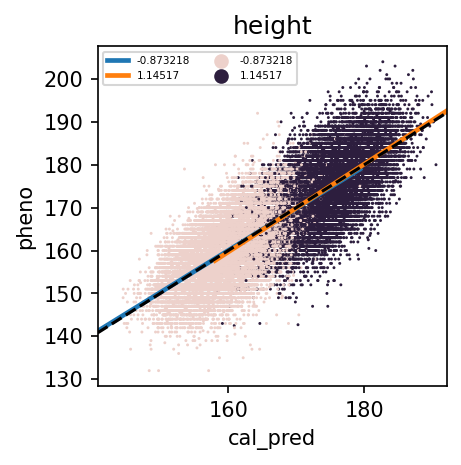

In [168]:
plot_group(df_predint, "SEX")

In [169]:
from scipy.stats import linregress

In [170]:
def display_stats(df, group):
    if len(np.unique(df[group])) > 5:
        q_var = pd.qcut(df[group], 5)
    else:
        q_var = df[group]

    print("## slope of pheno ~ pred:")
    display(
        df.assign(q=q_var)
        .groupby("q")
        .apply(
            lambda tmp: sm.OLS(
                endog=tmp["pheno"], exog=sm.add_constant(tmp["cal_pred"])
            )
            .fit()
            .params[1]
        )
    )
    print("## residual variance of pheno ~ pred:")
    display(
        df.assign(q=q_var)
        .groupby("q")
        .apply(lambda tmp: np.mean((tmp["pheno"] - tmp["cal_pred"]) ** 2))
    )
    print("## total variance of pheno")
    display(df.assign(q=q_var).groupby("q").apply(lambda tmp: np.var(tmp["pheno"])))

    print("## total variance of pred")
    display(df.assign(q=q_var).groupby("q").apply(lambda tmp: np.var(tmp["cal_pred"])))

    print("## Pearson's R2 of pheno ~ pred:")
    display(
        df.assign(q=q_var)
        .groupby("q")
        .apply(lambda tmp: stats.pearsonr(tmp["pheno"], tmp["cal_pred"])[0] ** 2)
    )

In [171]:
display_stats(df_predint, "SEX")

## slope of pheno ~ pred:


q
-0.873218    0.979810
 1.145170    1.024709
dtype: float64

## residual variance of pheno ~ pred:


q
-0.873218    24.301033
 1.145170    29.039804
dtype: float64

## total variance of pheno


q
-0.873218    43.079350
 1.145170    50.282968
dtype: float64

## total variance of pred


q
-0.873218    19.568509
 1.145170    20.242814
dtype: float64

## Pearson's R2 of pheno ~ pred:


q
-0.873218    0.436086
 1.145170    0.422719
dtype: float64

In [172]:
display_stats(df_predint, "AGE")

## slope of pheno ~ pred:


q
(-2.0829999999999997, -1.033]    0.996899
(-1.033, -0.334]                 0.993773
(-0.334, 0.365]                  1.003275
(0.365, 1.064]                   1.007089
(1.064, 1.996]                   0.999720
dtype: float64

## residual variance of pheno ~ pred:


q
(-2.0829999999999997, -1.033]    28.215737
(-1.033, -0.334]                 27.427885
(-0.334, 0.365]                  26.067582
(0.365, 1.064]                   24.971710
(1.064, 1.996]                   24.806296
dtype: float64

## total variance of pheno


q
(-2.0829999999999997, -1.033]    86.437521
(-1.033, -0.334]                 85.687537
(-0.334, 0.365]                  86.166233
(0.365, 1.064]                   84.927106
(1.064, 1.996]                   82.312337
dtype: float64

## total variance of pred


q
(-2.0829999999999997, -1.033]    58.585411
(-1.033, -0.334]                 58.998976
(-0.334, 0.365]                  59.710286
(0.365, 1.064]                   59.117907
(1.064, 1.996]                   57.540325
dtype: float64

## Pearson's R2 of pheno ~ pred:


q
(-2.0829999999999997, -1.033]    0.673580
(-1.033, -0.334]                 0.679988
(-0.334, 0.365]                  0.697513
(0.365, 1.064]                   0.706006
(1.064, 1.996]                   0.698657
dtype: float64

In [173]:
fit = sm.OLS(df_predint["pheno"], sm.add_constant(df_predint["cal_pred"])).fit()

In [174]:
df_tmp = df_predint[df_predint.SEX < 0]
fit1 = sm.OLS(df_tmp["pheno"], sm.add_constant(df_tmp["cal_pred"])).fit()
df_tmp = df_predint[df_predint.SEX > 0]
fit2 = sm.OLS(df_tmp["pheno"], sm.add_constant(df_tmp["cal_pred"])).fit()

In [175]:
print("Covariates that have largest gamma")
df_params.assign(gamma_abs=df_params["gamma"].abs()).sort_values(
    "gamma_abs", ascending=False
).head(n=10)

Covariates that have largest gamma


,beta,beta_se,beta_z,gamma,gamma_se,gamma_z,slope,slope_se,slope_z,gamma_abs
const,167.134000,0.018830,8876.01000,3.254500,0.005137,633.55000,NaN,NaN,NaN,3.254500
PC1,7.216680,0.025845,279.23100,0.128150,0.006304,20.32960,-0.038945,0.000139,-279.9750,0.128150
SEX,7.425210,0.019127,388.21100,0.087325,0.005303,16.46840,-0.005830,0.000114,-51.1035,0.087325
DEPRIVATION_INDEX,0.238983,0.021310,11.21440,0.049763,0.005873,8.47338,-0.002985,0.000128,-23.2876,0.049763
PGS,4.069090,0.019075,213.31900,0.047693,0.005437,8.77152,-0.002909,0.000117,-24.9632,0.047693
PC4,0.672290,0.020909,32.15300,-0.042664,0.005974,-7.14114,-0.002512,0.000131,-19.2028,0.042664
AGE,-0.160459,0.021013,-7.63615,-0.034235,0.005891,-5.81117,-0.007005,0.000127,-55.1084,0.034235
PC5,-0.727536,0.020104,-36.18840,-0.029214,0.006115,-4.77705,0.002483,0.000126,19.7010,0.029214
income,-0.311489,0.020376,-15.28670,-0.025684,0.005715,-4.49441,0.004745,0.000123,38.4761,0.025684
PC3,-1.814780,0.020336,-89.24140,0.024737,0.005455,4.53440,0.006871,0.000119,57.7162,0.024737


In [176]:
plot_covar_list = ["PC1", "AGE", "SEX", "log_BMI", "pheno"]

In [177]:
# quantile range based on point prediction
q_min = 0.8
q_max = 0.85

# number of individuals to show
n_indiv = 50
assert n_indiv % 2 == 0

In [178]:
def format_df_plot(df):
    df = df.copy()
    for col in ["AGE", "SEX"]:
        if col in df.columns:
            df[col] = df_raw[col][df.index]

    if "SEX" in df:
        df["SEX"] = df["SEX"].apply(lambda s: "Male" if s == 1 else "Female")

    df = df.rename(
        columns={
            "SEX": "Sex",
            "DEPRIVATION_INDEX": "Deprivation",
            "AGE": "Age",
        }
    )
    df = df.round(2)
    return df

In [181]:
df_plot = df_predint[
    df_predint["cal_pred"].between(
        df_predint["cal_pred"].quantile(q=q_min),
        df_predint["cal_pred"].quantile(q=q_max),
    )
]
# df_plot = df_plot.query("cal_predstd < 0.8")
df_plot = df_plot.query("cal_predstd > 1.0")

In [182]:
np.mean((df_plot["pheno"] - df_plot["cal_pred"]).abs() < df_plot["cal_predstd"] * 1.96)

0.9493804376482995

In [183]:
df_plot = df_predint[
    df_predint["cal_pred"].between(
        df_predint["cal_pred"].quantile(q=q_min),
        df_predint["cal_pred"].quantile(q=q_max),
    )
]

df_plot = (
    df_plot.sort_values("cal_predstd")
    .iloc[list(np.arange(0, n_indiv // 2)) + list(np.arange(-n_indiv // 2, 0)), :][
        [*plot_covar_list, "cal_pred", "cal_predstd"]
    ]
    .copy()
)

df_plot = format_df_plot(df_plot)
df_plot.index = np.arange(1, len(df_plot) + 1)

In [184]:
display(df_plot)

,PC1,Age,Sex,log_BMI,pheno,cal_pred,cal_predstd
1,-0.59,61,Male,0.31,178.0,175.44,4.55
2,-0.57,67,Male,-0.39,177.0,175.66,4.59
3,-0.58,60,Male,-0.73,171.0,175.82,4.60
4,-0.59,64,Male,-0.11,173.0,174.58,4.62
5,-0.58,67,Male,-0.05,178.0,175.27,4.62
6,-0.59,52,Male,-0.65,174.0,175.77,4.63
7,-0.59,62,Male,0.42,174.0,174.62,4.63
8,-0.59,65,Male,-0.10,171.0,175.45,4.64
9,-0.60,62,Male,0.45,173.0,174.85,4.64
10,-0.58,50,Male,-0.40,175.0,175.14,4.64


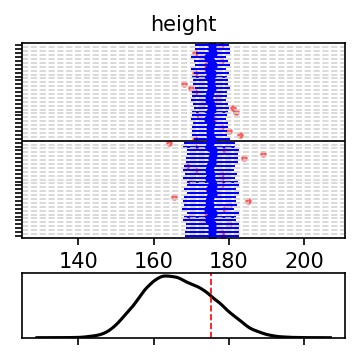

In [185]:
fig, axes = plt.subplots(
    figsize=(2.5, 2.5), dpi=150, nrows=2, gridspec_kw={"height_ratios": [3, 1]}
)
n_indiv = len(df_plot)
axes[0].errorbar(
    y=np.arange(n_indiv - 1, -1, -1),
    x=df_plot["cal_pred"],
    xerr=df_plot["cal_predstd"],
    fmt=".",
    color="blue",
    lw=1.0,
)
axes[0].scatter(
    y=np.arange(n_indiv - 1, -1, -1), x=df_plot["pheno"], alpha=0.5, color="red", s=5
)
for i in range(n_indiv - 1):
    axes[0].axhline(y=i + 0.5, ls="--", color="lightgray", lw=0.8)

axes[0].axhline(y=(n_indiv - 1) / 2, ls="-", color="black", lw=0.8)
axes[0].set_ylim(-0.5, n_indiv - 0.5)
axes[0].set_yticks(np.arange(n_indiv))
axes[0].set_yticklabels([])

sns.kdeplot(df_predint["pheno"].values, ax=axes[1], color="black")
axes[1].set_yticks([])
axes[1].set_ylabel(None)
axes[0].set_xlim(axes[1].get_xlim())
axes[1].set_xticklabels([])

axes[0].axvline(x=df_plot["cal_pred"].mean(), ls="--", lw=0.8, color="red")
axes[1].axvline(x=df_plot["cal_pred"].mean(), ls="--", lw=0.8, color="red")
axes[0].set_title(f"{trait}", fontsize=10)

fig.tight_layout()
plt.subplots_adjust(hspace=0.27)

Text(0, 0.5, 'Observed standard deviation')

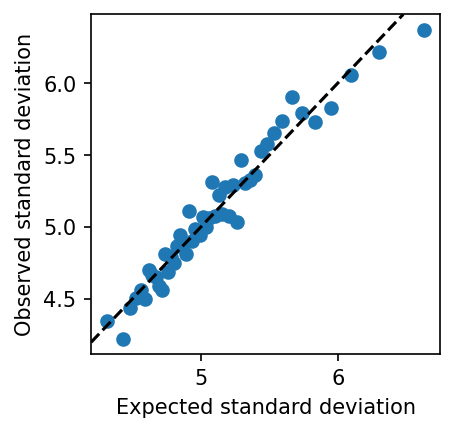

In [186]:
df_tmp = df_predint.copy()
df_tmp["cal_predstd_q"] = pd.qcut(df_tmp["cal_predstd"], q=50).cat.codes

a = df_tmp.groupby("cal_predstd_q").apply(lambda df: np.mean(df["cal_predstd"]))
b = df_tmp.groupby("cal_predstd_q").apply(
    lambda df: np.sqrt(np.mean((df["cal_pred"] - df["pheno"]) ** 2))
)
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.scatter(a, b)
ax.axline((a[0], a[0]), slope=1, color="black", ls="--")
ax.set_xlabel("Expected standard deviation")
ax.set_ylabel("Observed standard deviation")